In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import OPTICS
from sklearn.mixture import BayesianGaussianMixture 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Dense, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU

import keras_radam
from keras_radam import RAdam
from tensorflow.keras.utils import plot_model

import numpy as np
import joblib 
import matplotlib.pyplot as plt

from CRISMrelatedMethods.preprocessing import *
from CRISMrelatedMethods.dataRead import *

-----------------------------------------------------------------------------------

## Read MICA Spectral Library
Downloaded from https://crismtypespectra.rsl.wustl.edu

In [2]:
spectralLibPath='../../spectralLibrary/'
spectralWavelength,spectralIF,mineralNames,spectralWavelengthSet_1=readSpectralLib(spectralLibPath)

print(mineralNames)

{0: 'alunite', 1: 'al_smectite', 2: 'analcime', 3: 'bassanite', 4: 'chloride', 5: 'chlorite', 6: 'co2_ice', 7: 'epidote', 8: 'fe_ca_carbonate', 9: 'fe_olivine', 10: 'fe_smectite', 11: 'gypsum', 12: 'h2o_ice', 13: 'hcp', 14: 'hematite', 15: 'hydrated_silica', 16: 'hydrox_fe_sulf', 17: 'illite_muscovite', 18: 'jarosite', 19: 'kaolinite', 20: 'lcp', 21: 'margarite', 22: 'mg_carbonate', 23: 'mg_olivine', 24: 'mg_smectite', 25: 'mono_hyd_sulf', 26: 'plagioclase', 27: 'poly_hyd_sulf', 28: 'prehnite', 29: 'serpentine', 30: 'talc'}


In [3]:
mineralGroupNames=['Iron oxides and primary silicates','Ices','Sulfates','Phyllosilicates','Carbonates','Hydrated silicates and halides']
mineralGroupList=[[14,23,9,26,20,13],[6,12],[0,27,25,3,18,11,16],[19,1,21,17,10,24,30,29,5],[8,22],[28,7,15,2,4]]
mineralGroupDict={g:G for G in range(len(mineralGroupList)) for g in mineralGroupList[G] }

saveVarInfo('specifications.z','mineralNames',mineralNames)
saveVarInfo('specifications.z','mineralGroupNames',mineralGroupNames)
saveVarInfo('specifications.z','mineralGroupList',mineralGroupList)
saveVarInfo('specifications.z','mineralGroupDict',mineralGroupDict)

##  Data Augmentation

In [4]:
perMineralAug=5000

X,y=[],[]
shiftAug=0
mineralCount=-1
mineralIndexMap={}
originalSpectraList=[]
for file_index in range(len(mineralNames)):
    mineralCount+=1
    mineralIndexMap[mineralCount]=file_index
    interpFunc=interp1d(spectralWavelength[file_index],spectralIF[file_index], kind='linear')
    originalSpectra=interpFunc(spectralWavelengthSet_1)
    originalSpectraList.append(originalSpectra)
    for i in range(perMineralAug):
        noisedSpectra=getContiNoised(getShiftNoised(originalSpectra),noiseStd=0.0075*(i%11),targetWL=spectralWavelengthSet_1)
        X.append(noisedSpectra)
        y.append(mineralCount)  
X=np.array(X)
y=np.array(y)

## Preprocessing of Augmented Data

fixing wavelength domain

In [5]:
Wstart,Wend=1.05,2.6
sInd,eInd=len([w for w in spectralWavelengthSet_1 if w<Wstart]),len(spectralWavelengthSet_1)-len([w for w in spectralWavelengthSet_1 if w>Wend])
spectralWavelengthSet=spectralWavelengthSet_1[sInd:eInd]

saveVarInfo('specifications.z','spectralWavelengthSet',spectralWavelengthSet)

cropping

In [6]:
X_cr=X[:,sInd:eInd]

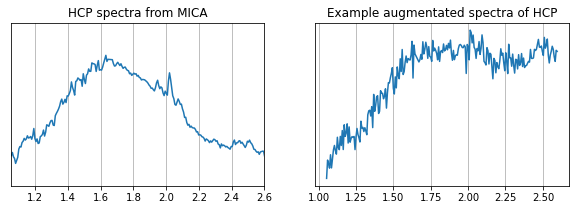

In [7]:
mineralindex=13
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(spectralWavelength[mineralindex],spectralIF[mineralindex])
plt.xlim(Wstart,Wend)
plt.ylim(.17,.2)
plt.yticks([])
plt.grid()
plt.title('HCP spectra from MICA')

plt.subplot(1,2,2)
plt.plot(spectralWavelengthSet,X_cr[mineralindex*perMineralAug+13])
plt.yticks([])
plt.grid()
plt.title('Example augmentated spectra of HCP')
plt.show()

smoothing

In [8]:
X_crsm=getSmoothedData(X_cr)

Contunuum Removal

In [9]:
X_crsmCR=getContinuumRemovedData(X_crsm)

Standard Scaler

In [10]:
X_crsmCRSS=getStandardScaledData(X_crsmCR)

Feature Extraction

In [11]:
P=getDiversePositions(spectralIF,spectralWavelength,spectralWavelengthSet)
X_crsmCRSSFE=getFeatureData(X_crsmCRSS,spectralWavelength,P)

## Saving Prepsocessed Data

In [12]:
data_X_prep={}
data_X_prep['_']=X
data_X_prep['cr']=X_cr
data_X_prep['crsm']=X_crsm
data_X_prep['crsmCR']=X_crsmCR
data_X_prep['crsmCRSS']=X_crsmCRSS
data_X_prep['crsmCRSSFE']=X_crsmCRSSFE

data_X_prep['crCR']=getContinuumRemovedData(X_cr)
data_X_prep['crsmSS']=getStandardScaledData(X_crsm)

In [13]:
joblib.dump(data_X_prep,'AugmentedPrep_X.z')
joblib.dump(y,'AugmentedPrep_Y.z')

['AugmentedPrep_Y.z']

-----------------------------------------------------------------------------------

## Labelled Test Data

Downloaded from https://cs.iupui.edu/~mdundar/CRISM.htm (‘Ratioed training dataset for mineral classes’)

In [14]:
plebaniMICAclass={11:0, 1:6, 2:12, 3:11, 4:16, 6:10, 7:24, 8:28, 9:18, 10:29, 13:8, 18:1, 15:19, 17:7, 23:17, 25:2, 26:25, 27:15, 30:22, 31:5, 33:20, 35:13, 36:9, 37:4, 5:14, 19:27, 34:23, 16:3}
plebaniMICAclass_rev={plebaniMICAclass[p]:p for p in plebaniMICAclass}

saveVarInfo('specifications.z','plebaniMICAclass',plebaniMICAclass)
saveVarInfo('specifications.z','plebaniMICAclass_rev',plebaniMICAclass_rev)

In [17]:
perLabelData=1000
plebaniMICA_X,plebaniMICA_Y,spectralWavelengthSet_2=getPlebaniData('../../CRISM_labeled_pixels_ratioed',plebaniMICAclass,spectralWavelengthSet_1,perLabelData=perLabelData)  # 1000 spectra per class

In [21]:
Wstart,Wend=spectralWavelengthSet_2[0],spectralWavelengthSet_2[-1]
sInd,eInd=len([w for w in spectralWavelengthSet_1 if w<Wstart]),len(spectralWavelengthSet_1)-len([w for w in spectralWavelengthSet_1 if w>Wend])
data_X_prep['_']=data_X_prep['_'][:,sInd:eInd]
joblib.dump(data_X_prep,'AugmentedPrep_X.z')

['AugmentedPrep_X.z']

In [23]:
list(plebaniMICA_Y).index(13)

21000

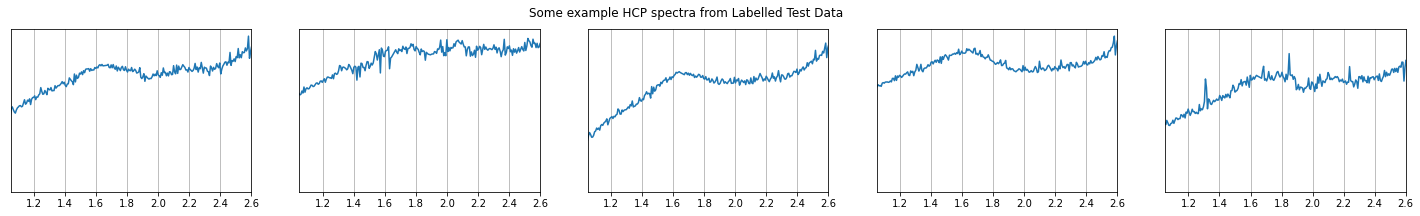

In [40]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet_2,plebaniMICA_X[21000+i])
    plt.yticks([])
    plt.xlim(1.05,2.6)
    plt.grid()
plt.show()

## Pre-processing

cropping

In [41]:
Wstart,Wend=1.05,2.6
sInd,eInd=len([w for w in spectralWavelengthSet_2 if w<Wstart]),len(spectralWavelengthSet_2)-len([w for w in spectralWavelengthSet_2 if w>Wend])
plebaniMICA_X_cr=plebaniMICA_X[:,sInd:eInd]

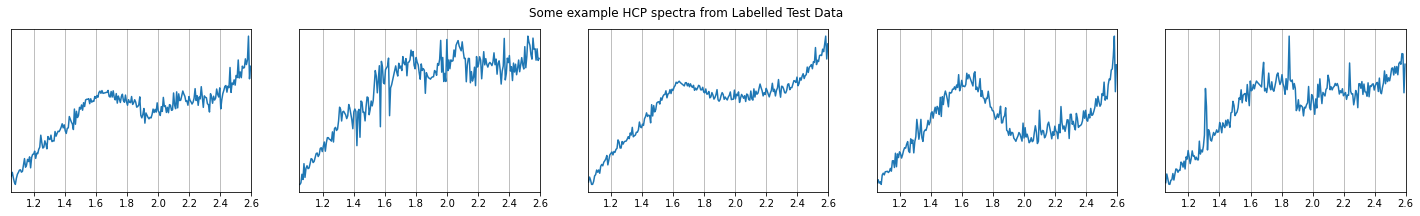

In [42]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_cr[21000+i])
    plt.yticks([])
    plt.xlim(1.05,2.6)
    plt.grid()
plt.show()

smoothing

In [44]:
plebaniMICA_X_crsm=getSmoothedData(plebaniMICA_X_cr)

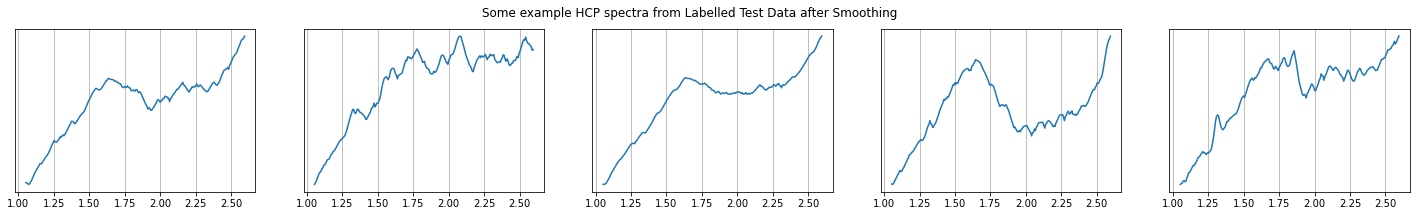

In [45]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_crsm[21000+i])
    plt.yticks([])
    plt.grid()
plt.show()

continuum removal

In [46]:
plebaniMICA_X_crsmCR=getContinuumRemovedData(plebaniMICA_X_crsm)

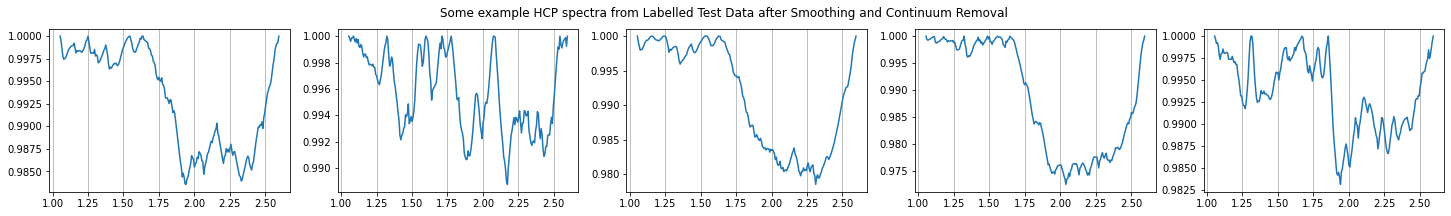

In [47]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing and Continuum Removal')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_crsmCR[21000+i])
    plt.gca().xaxis.grid(True)
plt.show()

standard scaler

In [48]:
plebaniMICA_X_crsmCRSS=getStandardScaledData(plebaniMICA_X_crsmCR)

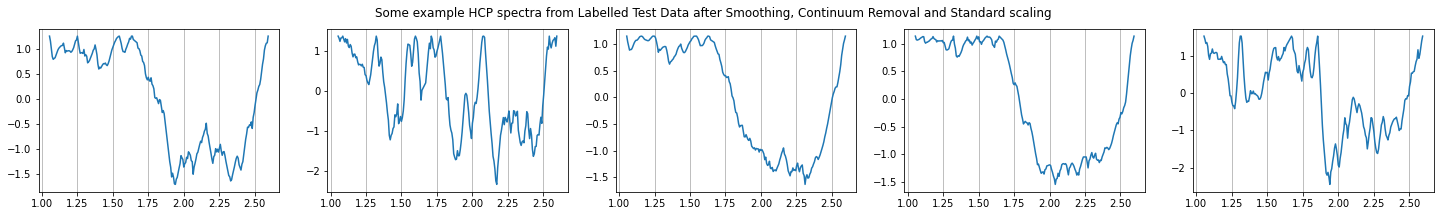

In [50]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing, Continuum Removal and Standard scaling')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_crsmCRSS[21000+i])
    plt.gca().xaxis.grid(True)
plt.show()

Absorption Feature Extraction

In [51]:
# P=getDiversePositions(spectralIF,spectralWavelength,spectralWavelengthSet)
plebaniMICA_X_crsmCRSSFE=getFeatureData(plebaniMICA_X_crsmCRSS,spectralWavelengthSet,P)

## Saving preprocessed test data

In [52]:
data_plebaniMICA_X_prep={}
data_plebaniMICA_X_prep['_']=plebaniMICA_X
data_plebaniMICA_X_prep['cr']=plebaniMICA_X_cr
data_plebaniMICA_X_prep['crsm']=plebaniMICA_X_crsm
data_plebaniMICA_X_prep['crsmCR']=plebaniMICA_X_crsmCR
data_plebaniMICA_X_prep['crsmCRSS']=plebaniMICA_X_crsmCRSS
data_plebaniMICA_X_prep['crsmCRSSFE']=plebaniMICA_X_crsmCRSSFE

data_plebaniMICA_X_prep['crCR']=getContinuumRemovedData(plebaniMICA_X_cr)
data_plebaniMICA_X_prep['crsmSS']=getStandardScaledData(plebaniMICA_X_crsm)

In [53]:
joblib.dump(data_plebaniMICA_X_prep,'plebaniMICA_testPrep_X.z')
joblib.dump(plebaniMICA_Y,'plebaniMICA_testPrep_Y.z')

['plebaniMICA_testPrep_Y.z']